# Projeto de análise de custos em nuvem --- Hyperledger Fabric

Este projeto tem como objetivo auxiliar na predição de recursos necessários para executar uma blockchain Hyperledger Fabric --- ou outras blockchains permissionadas privadas com comportamento similar.</br>
Além dos recursos analisados, com base nos atributos de configuração e transações por segundo (TPS), disponibilizamos uma estimativa de custos para executar elementos de uma organização na computação em nuvem</br>
</br>
Assim, o projeto é dividido em duas grandes seções: Predição de recursos e Calculadora de Custos em um ambiente Cloud.</br><br>

Nas seções, existem blocos que serão demarcados por " 🔵 " para sinalizar um bloco de parametrização e variaveis que podem ser alteradas



# Blockchain Predict (predição dos recursos)

## Configurações
É importante destacar que o modelo é baseado em configurações e entradas do usuário. É recomendado o conhecimento mínimo sobre uma blockchain Hyperledger Fabric e alguns testes preliminares para popular alguns campos. </br>
Na célula abaixo, a estrutura de dados ```BlockchainParameters```representa a configuração e parâmetros reais do arquivo de configuração da blockchain.
 </br>

### BlockchainParameters:
 
 ```GenesisBlockSize``` : indica o espaço ocupado pelo bloco gênese (primeiro bloco ao criar uma nova blockchain). Geralmente carrega poucas informações e na maioria dos casos pode ser irrelevante: <br>
 Os parâmetros listados abaixo interferem diretamente no comportamento da blockchain e devem ser analisados conforme necessidade.

 ```BatchSize```: O BatchSize é composto por dois parâmetros limites para garantir os valores máximos de informações em um bloco da blockchain.
 - ```AbsoluteMaxBytes```: esse parâmetro representa em Bytes qual deve ser o gatilho para o fechamento do bloco, isso é, ao ser atingido o valor de informações, o bloco deve ser fechado e gerado um novo bloco na cadeia.
 - ```MaxMessageCount```: esse parâmetro indica a quantidade de mensagens, no caso, limite transações que podem inseridas dentro do bloco
 ```BatchTimeout```: quando nenhum dos indicadores acima atingir seu gatilho, o *BatchTimeout* busca garantir o tempo máximo para espera do bloco em aberto.
```EndorsementPolicy```: define as políticas da rede para endosso --- assinatura e validação inicial de algum *peer* ---  das transações. O Endosso é normalmente representado por equações lógicas como OR(A,B), AND(A,B) ou OR(A,B,C). Para incluir nos cálculos a quantidades de transações que um Peer deve assinar, consideramos a distribuição das transações de forma uniforme entre os Peers dadas as condições configuradas (desconsiderando o comportamento **forçado** do *clients* em submeter somente a um *peer* para endosso). Nos exemplos OR(A,B), AND(A,B) ou OR(A,B,C) as transações requerem o total de endossos de Peers, respectivamente, 1/2, 2/2 ou 1/3.
<br> 
<br> 

### Tamanhos e campos (*BlockHeaders* e *TransactionFields*)
Durante a execução das transações na blockchain, os campos e cabeçalhos são preenchidos demandando bytes a serem armazenados. Os campos listados abaixo são utilizados posteriormente os cálculos de armazenamento. <br><br>
Esses campos podem ser dimensionados com base no SmartContract executado com alguns experimentos para estimar o seu tamanho. Reccomendamos que utilize a ferramenta [Hyperledger Caliper](https://www.hyperledger.org/projects/caliper) para compor a análise.
Em suma, os campos de ```BlockHeaders``` são campos com valores definidos após o bloco ser encadeado. ```TransactionFields``` por outro lado são campos presentes em cada transação. <br><br>
Mais detalhes na [documentação](https://hyperledger-fabric.readthedocs.io/en/release-2.5/ledger/ledger.html) nas seções [BlockHeaders](https://hyperledger-fabric.readthedocs.io/en/release-2.5/_images/ledger.diagram.4.png)  e [TransactionFields](https://hyperledger-fabric.readthedocs.io/en/release-2.5/_images/ledger.diagram.5.png)


In [197]:
# { 🔵 }

CONF = {
  "BlockchainParameters": {
    "GenesisBlockSize": 0, 
    "BatchSize": {
      "AbsoluteMaxBytes": 10485760,  # Bytes
      "MaxMessageCount": 100000
    }, 
    "BatchTimeout": 600, #Seconds
  "EndorsementPolicy": 1/2,
  }, 

  "BlockHeaders": { # Bytes
    "MetadataSize": 64, 
    "HeaderSize": 128
  }, 

  "TransactionFields": {#Bytes
    "R4": 128, 
    "E4": 512, 
    "H4": 64, 
    "P4": 256, 
    "S4": 256
  },
  
}



In [198]:
# { 🔵 }
CLOUD_PRICING = {
    "Storage": {
      "Pricing": 0.045
    }, 
    "NetworkThroughput": {
      "Pricing": 0.01
    }, 
    "VirtualMachine": {
      "FilePricing": "./Amazon EC2 Instance Comparison.csv", #null requires insert manual values InstancesTypes
       "InstancesTypes": [
      # E.g:
      #   {"VCPU": 2,  "Pricing": 0.0388},
      #   {"VCPU": 4,  "Pricing": 0.0776},
      #   {"VCPU": 8,  "Pricing": 0.1552},
      #   {"VCPU": 16,  "Pricing": 0.3104},
       ]
      
    }, 
    "Additional": 0 # E.g: taxes or discounts
  }

In [199]:
#%matplotlib inline #<< É necessário utilizar se estiver no VSCODE

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

import numpy as np
import pandas as pd
from pandas.plotting import table

pd.options.display.float_format = '${:,.2f}'.format


import pprint

In [200]:
#predict.py
TRANSACTION_SIZE     =  np.sum(np.array([fields_values for fields_values in CONF['TransactionFields'].values()]))
BLOCK_HEADERS_SIZE   =  np.sum(np.array([fields_values for fields_values in CONF['BlockHeaders'].values()]))

def calculate_size_total_transacoes(self, total_transactions:int, transaction_size:int) -> int:
   self.size_total_transacoes = total_transactions * transaction_size
   if self.size_total_transacoes > self.absolute_max_bytes:
      print('Undefined: size_total_transacoes > absolute_max_bytes')
      print('size_total_transacoes : ', self.size_total_transacoes)
      return -1
   return self.size_total_transacoes

class StorageDemand:
    def __init__(self):
        self.total_blocks = 0
        self.total_transactions = 0
        self.calculated_total_size_blocks = 0
        self.batch_type = ""
        self.period = 0

class CostPredict:
    def __init__(self):
        self.file_pricing                = CLOUD_PRICING['VirtualMachine']['FilePricing']
        self.instanc_types               = CLOUD_PRICING['VirtualMachine']['InstancesTypes']
        self.storage_pricing             = CLOUD_PRICING['Storage']['Pricing']
        self.network_throughput_pricing  = CLOUD_PRICING['NetworkThroughput']['Pricing']
        self.additional                  = CLOUD_PRICING['Additional']

In [201]:
def logistic_curve(t, P0, K, r, t0):
    return P0 + (K - P0) / (1 + np.exp(-r * (t - t0)))

### Modelagem da curva de adoção
Para uma modelagem mais abrangente, as predições são geradas com base no tipo período da variável ```PREDICT_TYPE``` que assume os valores de: 'DAY' para dias, 'WEEK' para semana, 'MONTH' para mês e YEAR' para anos. 
<br><br>
Há duas formas de inserir comportamentos estimados de transações por segundo no ambiente.
1. ARRAY: Inserir valores de TPS diretamente no Array 
2. Função Logística: Ajustar os parametros da função logística para gerar algum comportamento ao longo do período (**deixar o ARRAY vazio para auto seleção*)

A função de regressão logística pode simplificar na visualização e estimativas da adoção da tecnologia. Ainda que para uma organização em longo prazo seja díficil ter certeza sobre a demanda de transações, o gráfico da curva pode assumir diferentes comportamentos e auxiliar visualmente na modelagem.

In [202]:
# 🔵 Required PREDICT_TYPE

global PREDICT_TYPE
PREDICT_TYPE = 'MONTH' # 🔵 'DAY':'WEEK':'MONTH':'YEAR'

In [203]:
# 🔵 Caso array [vazio]
global AVG_RATE_TRANSACTIONS

ARRAY = []# 🔵 E.g [50,100,150,200,250,320,370,550,750,1000]
AVG_RATE_TRANSACTIONS = np.array(ARRAY)

In [204]:
# 🔵 Caso Função Logística (default)

A = 120         # 🔵 Numero de períodos. E.g: para 18 meses => PREDICT_TYPE = 'MONTH' e A = 18 

t = np.linspace(0, A - 1, A)

# Parâmetros da curva logística
P0 = 5         # 🔵 Transações inicial
K = 1000       # 🔵 Valor máximo transações estimado
r =  0.15      # 🔵 Taxa de crescimento
t0 = A / 4     # 🔵 Ponto de inflexão -> Meio

# Calcula a população usando a função da curva logística

if len(ARRAY) == 0: # Ativar função logística
    AVG_RATE_TRANSACTIONS = logistic_curve(t, P0, K, r, t0)



In [205]:
# Cod Auxiliar de plotagens
def simple_plot(x,y,line_label="", xlabel=f'Tempo ({PREDICT_TYPE})', ylabel="", title="", v_grid=True, tlabel_style="plain", create_df=False):
    #print(f'Ultimo valor "{line_label}" => {y[-1]}')
    if create_df:
        fig, (ax, ax2)= plt.subplots(1, 2, figsize=(12, 4))
    else:
        fig, ax = plt.subplots()
    
    ax.plot(x,y,label=line_label)
    ax.ticklabel_format(style=tlabel_style)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    ax.grid(v_grid)
    
    df = pd.DataFrame({xlabel: x, line_label:y})
    if create_df:

        filter_df = df
        filter_df[line_label] = filter_df[line_label].map('{:,.2f}'.format)

        ax2.axis('off')  # Ocultar os eixos do subplot
        col_widths = [0.3, len(line_label)*0.015]
        tbl = table(ax2, filter_df.iloc[0:A:int(A/(A/10))], loc='center', colWidths=col_widths)
        tbl.auto_set_font_size(False)
        tbl.set_fontsize(10)
        tbl.scale(1.2, 1.2)

        # Ajustar o layout para evitar sobreposição
        plt.tight_layout()

    return fig, ax, df

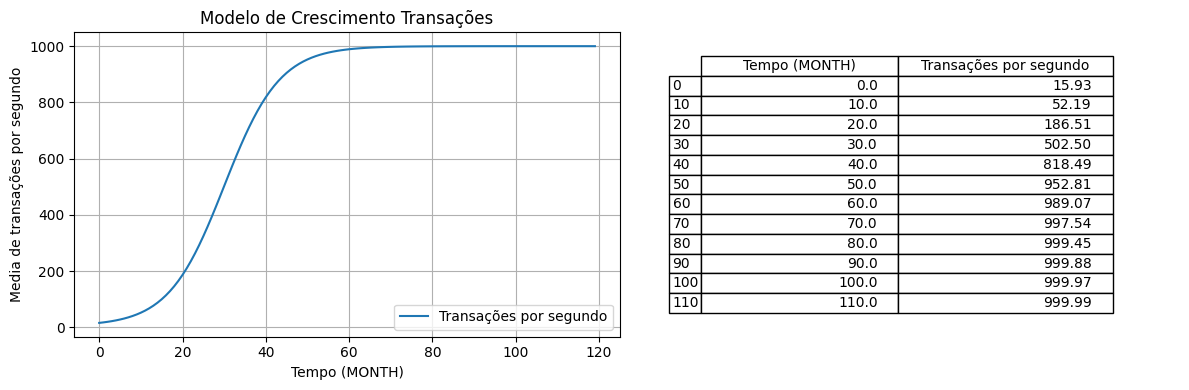

In [206]:
#Plotagem da curva de transações com base nas entradas
fig, ax, df = simple_plot(x= t,y= AVG_RATE_TRANSACTIONS, line_label= 'Transações por segundo', ylabel= 'Media de transações por segundo', title= 'Modelo de Crescimento Transações', create_df=True)
plt.show()


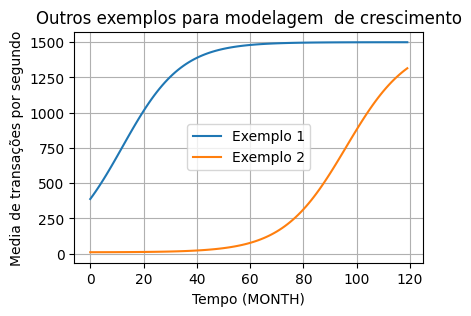

In [207]:
# Exemplos de modelagem auxiliar

A = 120         # Numero de períodos

t = np.linspace(0, A - 1, A)

# Parâmetros da curva logística
P0 = 10         # Transações inicial
K = 1500       # Valor máximo transações estimado
r =  0.09       # Taxa de crescimento
t0 = A/10     # Ponto de inflexão 

example_curve_1 = []
if len(ARRAY) == 0: # Ativar função logistica
    example_curve_1 = logistic_curve(t, P0, K, r, t0)

r =  0.085      # Taxa de crescimento
t0 = A-(A/5)     # Ponto de inflexão 
example_curve_2 = []
if len(ARRAY) == 0: # Ativar função logistica
    example_curve_2 = logistic_curve(t, P0, K, r, t0)




fig, ax, df = simple_plot(x= t,y= example_curve_1, line_label= 'Exemplo 1', ylabel= 'Media de transações por segundo', title= 'Outros exemplos para modelagem  de crescimento')
ax.plot(t, example_curve_2, label='Exemplo 2')
ax.legend()
fig.set_size_inches(4.5,3)
plt.show()



### Demanda de Armazenamento e Transações

**TRANSAÇÕES**

In [208]:

def expand_transactions_by_period(predict_type, rate_transactions_per_second):
    SECONDS_PER_DAY  = 86400
    return {
    'DAY': lambda rate_transactions_per_second: rate_transactions_per_second * SECONDS_PER_DAY,
    'WEEK': lambda rate_transactions_per_second: rate_transactions_per_second * SECONDS_PER_DAY * 7,
    'MONTH': lambda rate_transactions_per_second: rate_transactions_per_second * SECONDS_PER_DAY * 30,
    'YEAR': lambda rate_transactions_per_second: rate_transactions_per_second * SECONDS_PER_DAY * 365
    }[predict_type](rate_transactions_per_second)

total_transactions_by_period = expand_transactions_by_period(PREDICT_TYPE, AVG_RATE_TRANSACTIONS)

In [209]:
endorsement_transactions = total_transactions_by_period * CONF['BlockchainParameters']['EndorsementPolicy']

Abaixo, a plotagem da soma do total 'Transações (Committed)' no período apresenta uma expansão de transações por **segundo** para o período escolhido. Por exemplo, para uma predição ```PREDICT_TYPE = DAY``` para dias, dado o valor de X transações por segundo (TPS), resultado na soma de transações equivalente a Y transações total no dia
<br>
O gráfico é exibido em notação científica para melhorar a visualização.
<br>

💡 'Transações (Committed)' são aquelas gravadas na blockchain

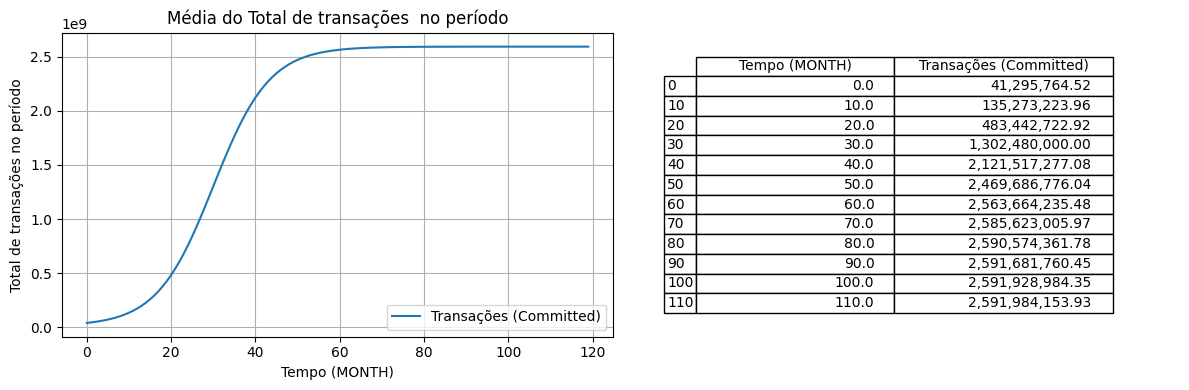

In [210]:
# Plotagem da soma do total transações estimada no período style='scientific'
fig, ax, df = simple_plot(x= t, y= total_transactions_by_period, line_label= 'Transações (Committed)', ylabel= 'Total de transações no período', title= 'Média do Total de transações  no período', tlabel_style='scientific', create_df=True)
plt.show()

#### ESTIMATIVA DE GERAÇÃO DOS BLOCOS:
<br>

Com a informação de TPS e a soma de transações em um período, podemos estimar a quantidade de blocos gerados a partir das configurações de ```BatchSize = AbsoluteMaxBytes | MaxMessageCount``` e ```BatchTimeout``` conforme descrevemos na seção de configurações.
<br>

A quantidade de blocos tem impacto na rede, pois a quantidade de blocos multiplicado pelos [tamanhos de cabeçalho](#tamanhos-e-campos-blockheaders-e-transactionfields) será computado também no total de armazenamento.
<br>

Além disso, sabendo a quantidade de transações dentro de um bloco e o [tamanho de cada transação](#tamanhos-e-campos-blockheaders-e-transactionfields) podemos estimar o tamanho total do bloco, e cumulativamente o tamanho total da blockchain.

In [211]:
# Bloco principal da análise de geração de blocos com base nas transações
def estimate_blocks(avg_tps, total_transactions_period):
    total_blocks = None
    batch_type  = ""
    
    #Qual o tempo necessário para fechar um bloco para max_message
    time_to_batch_messages = CONF['BlockchainParameters']['BatchSize']['MaxMessageCount'] / avg_tps

    #Quantas transações são necessárias para fechar um bloco com max_bytes
    aggregate_total_transactions_if_batch_max_bytes = CONF['BlockchainParameters']['BatchSize']['AbsoluteMaxBytes'] / TRANSACTION_SIZE
    time_to_batch_bytes  = aggregate_total_transactions_if_batch_max_bytes / avg_tps

    total_blocks = None
    
    if time_to_batch_messages >= CONF['BlockchainParameters']['BatchTimeout']  and \
            time_to_batch_bytes >=  CONF['BlockchainParameters']['BatchTimeout'] :# calcular para encadeamento batchtimeout

        
        aggregate_total_transactions_if_batch_timeout = CONF['BlockchainParameters']['BatchTimeout'] * avg_tps
        total_blocks = total_transactions_period / aggregate_total_transactions_if_batch_timeout
        batch_type = "batch_timeout"

    elif time_to_batch_messages < time_to_batch_bytes: # calcular para encadeamento batch messages
        total_blocks = total_transactions_period / time_to_batch_messages
        batch_type = "batch_message"
        
    
    elif time_to_batch_bytes    < time_to_batch_messages:# calcular para encadeamento batch bytes
        total_blocks = total_transactions_period / time_to_batch_bytes
        batch_type = "batch_bytes"
        
    else:
        raise Exception
        
    
    return total_blocks, batch_type

storage_demand = []
for i_period in range(0,A): 

    avg_t = AVG_RATE_TRANSACTIONS[i_period]
    transactions_by_period = total_transactions_by_period[i_period]

    i_storage_demand = StorageDemand() # Salvar no objeto com atributos que serão utilizados posteriormente
    i_storage_demand.period                                         = i_period    
    i_storage_demand.total_transactions                             = transactions_by_period
    i_storage_demand.total_blocks, i_storage_demand.batch_type      = estimate_blocks(avg_t, transactions_by_period)
    i_storage_demand.calculated_total_size_blocks                   = (i_storage_demand.total_blocks * BLOCK_HEADERS_SIZE) + (i_storage_demand.total_transactions * TRANSACTION_SIZE)
    
    storage_demand.append(i_storage_demand)
    


O total cumulativo de blocos é exibido abaixo. 

💡 Note que, sempre há um crescimento da quantidade de blocos e consequentemente da blockchain. Por exemplo, mesmo que a quantidade de ativos (*Assets*) se mantenha a mesma, cada transação pode alterar algum atributo e, consequentemente, cada alteração (transação) gerará um registro gravado na blockchain.
<br>
Esse fator implicará no custo de armazenamento que veremos a frente.



In [212]:
# Soma cumulativa dos tamanhos dos blocos
i_period           = np.array([s.period for s in storage_demand])
cumulative_blocks  = np.cumsum( np.array([s.total_blocks for s in storage_demand]) )

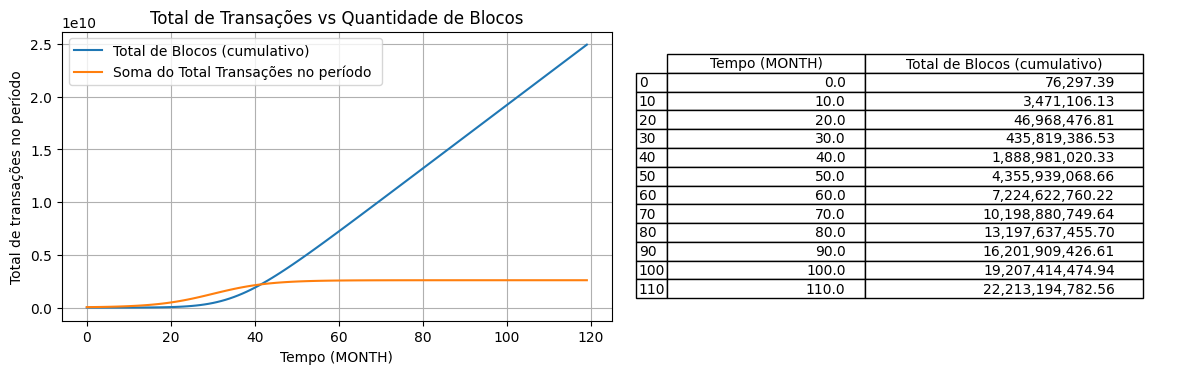

In [213]:
# Plotagem da soma do toal transações estimada no período
fig, ax, df = simple_plot(x= t, y= cumulative_blocks, line_label='Total de Blocos (cumulativo)', ylabel='Total de transações no período', title= 'Total de Transações vs Quantidade de Blocos', tlabel_style='sci', create_df=True)
ax.plot(t, total_transactions_by_period, label='Soma do Total Transações no período ')
ax.legend()
plt.show()

**ARMAZENAMENTO**

Com base nas informações do tamanho de cada bloco, podemos estimar a demanda de armazenamento total ao longo do período.

In [214]:
BYTE_TO_GIGA =  pow(1024 , 3)
cumulative_size_GB  = np.cumsum( np.array([s.calculated_total_size_blocks for s in storage_demand]) /  BYTE_TO_GIGA )

BYTE_TO_TERA =  pow(1024 , 4)
cumulative_size_TB  = np.cumsum( np.array([s.calculated_total_size_blocks for s in storage_demand]) /  BYTE_TO_TERA )

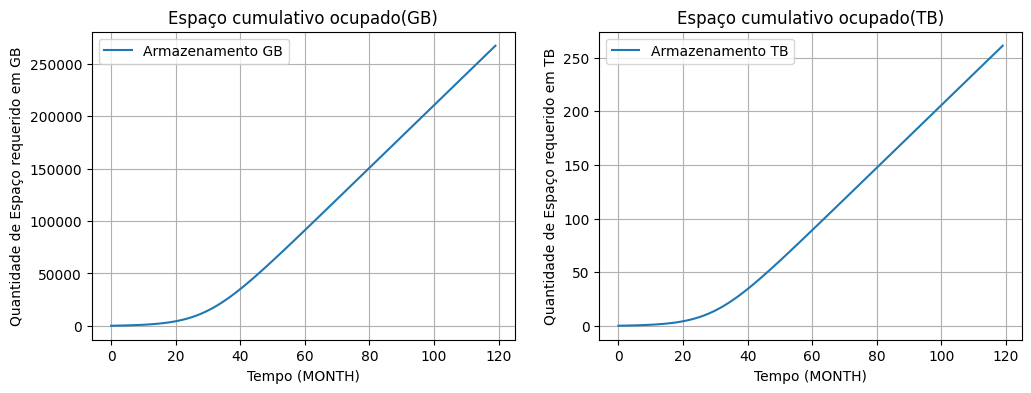

In [215]:
# ARMAZENAMENTO REQUERIDO GB / TB
# fig, ax, df1 = simple_plot(x= t, y=cumulative_size_GB, line_label='Armazenamento GB', ylabel='Quantidade de Espaço requerido em GB', title= 'Espaço cumulativo ocupado(GB)', tlabel_style='plain')
# fig, ax, df2 = simple_plot(x= t, y=cumulative_size_TB, line_label='Armazenamento TB', ylabel='Quantidade de Espaço requerido em TB', title= 'Espaço cumulativo ocupado(TB)', tlabel_style='plain')

xlabel=f'Tempo ({PREDICT_TYPE})'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(t,cumulative_size_GB,label='Armazenamento GB')
ax1.ticklabel_format(style='plain')
ax1.set_xlabel(xlabel)
ax1.set_ylabel('Quantidade de Espaço requerido em GB')
ax1.set_title('Espaço cumulativo ocupado(GB)')
ax1.legend()
ax1.grid(True)

ax2.plot(t,cumulative_size_TB,label='Armazenamento TB')
ax2.ticklabel_format(style='plain')
ax2.set_xlabel(xlabel)
ax2.set_ylabel('Quantidade de Espaço requerido em TB')
ax2.set_title('Espaço cumulativo ocupado(TB)')
ax2.legend()
ax2.grid(True)

plt.show()

## Demanda CPU

O consumo de CPU é estimado conforme a taxa de transações por segundo. No entanto, diferentes elementos da rede com diferentes workloads, necessitam processam quantidades de transações de forma independente.
<br>
No Hyperledger Fabric podemos considerar dois tipos de nodos que requerem maior capacidade de CPU: os Peers e Nodos de Ordenação (*Ordering Service*).



### Demanda CPU ~ Ordering Service

Na arquitetura do Hyperledger Fabric, os elementos que compõem a rede das organizações majoritariamente são os **Peers**, mas também é necessário um cluster de nodos responsáveis pela ordenação das transações (Ordering Service). Para este modelo, consideramos que a Organização manterá um dos nodos de ordenação em sua infraestrutura.

Abaixo são realizados os cálculos para estimativa da quantidade de CPU de ordenação necessária para o TPS total da rede. Essa estimativa é feita com base nas variáveis baseadas em um "benchmark" de performance que pode mensurado executando o Hyperledger Calyper e acompanhamento a carga na CPU.  ```vCPU_BASE_OSN``` e ```vCPU_BASE_TPS_OSN```, são respectivamente, a quantidade de CPU e o total de transações que as CPUs suportaram.

In [216]:
# { 🔵 }
vCPU_BASE_OSN     =  1
vCPU_BASE_TPS_OSN = 150 

In [217]:
aggregate_total_required_vcpu_osn = np.array([])

ordering_transactions = AVG_RATE_TRANSACTIONS

for tps in ordering_transactions:
    target_required_vcpu  = vCPU_BASE_OSN

    required_vcpu_current_tps = tps / vCPU_BASE_TPS_OSN

    if required_vcpu_current_tps > 1:
        target_required_vcpu = vCPU_BASE_OSN + (vCPU_BASE_OSN * int(required_vcpu_current_tps))
        
    aggregate_total_required_vcpu_osn = np.append(aggregate_total_required_vcpu_osn, target_required_vcpu)

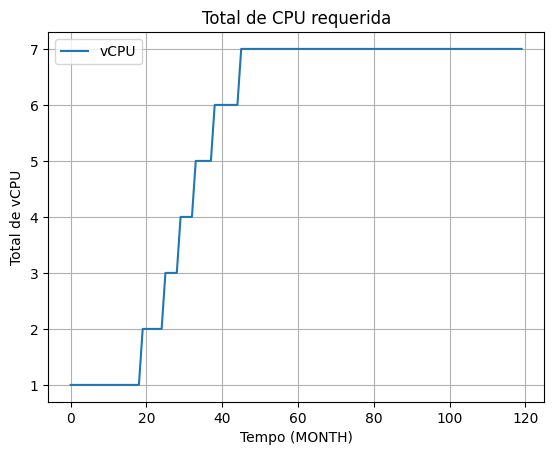

In [218]:
fig, ax, df = simple_plot(x= t, y=aggregate_total_required_vcpu_osn, line_label='vCPU', ylabel='Total de vCPU', title= 'Total de CPU requerida', tlabel_style='plain')
plt.show()

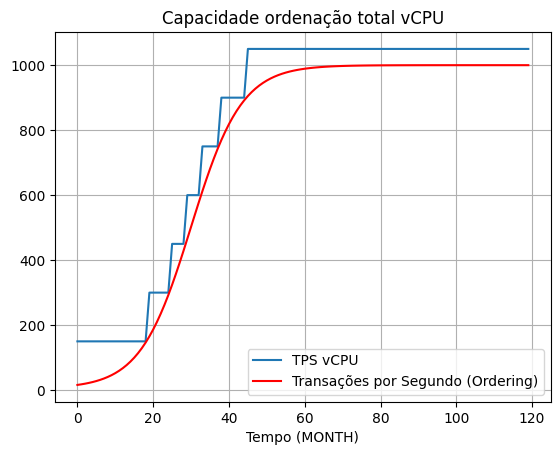

In [219]:
# Plotagem da soma do toal transações estimada no período
osn_total_vcpu_tps = aggregate_total_required_vcpu_osn*vCPU_BASE_TPS_OSN

fig, ax, df = simple_plot(x= t, y= osn_total_vcpu_tps, line_label='TPS vCPU ', ylabel='', title= 'Capacidade ordenação total vCPU', tlabel_style='plain')
ax.plot(t, ordering_transactions, label='Transações por Segundo (Ordering)', color='red')
plt.legend()
plt.show()



## CPU PEER

### Endorsement Transations

Plotagem da comparação 'Endorsement Transations' da rede em comparação ao total de transações *Commited* apresentado acima, com base no parametro ***EndorsementPolicy***
<br>
💡 'Endorsement Transations'  são aquelas que o peer deve pré-assinar para ser submetida na rede


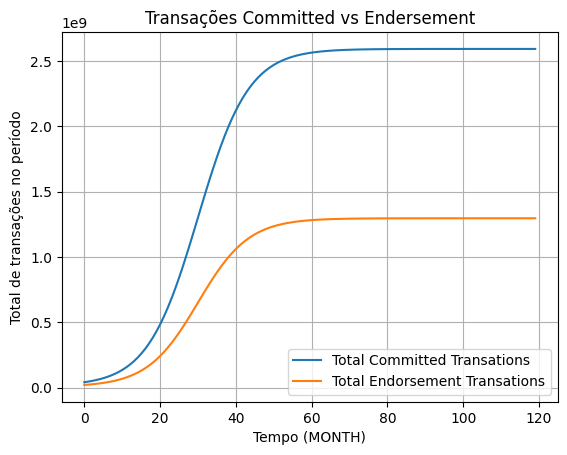

In [220]:
fig, ax, df = simple_plot(x= t, y= total_transactions_by_period, line_label='Total Committed Transations', ylabel= 'Total de transações no período', title= 'Transações Committed vs Endersement', tlabel_style='sci')
ax.plot(t, endorsement_transactions, label='Total Endorsement Transations')
ax.legend()
df
plt.show()

In [221]:
aggregate_total_required_vcpu_peer = np.array([])
vCPU_BASE     =  2
vCPU_BASE_TPS = 200 # 2vcpu = 200

peer_commited_transactions = AVG_RATE_TRANSACTIONS
peer_endorsement_transactions = AVG_RATE_TRANSACTIONS * CONF['BlockchainParameters']['EndorsementPolicy']
peer_endorsement_commited_transactions = peer_commited_transactions + peer_endorsement_transactions

for tps in peer_endorsement_commited_transactions:
    target_required_vcpu  = vCPU_BASE

    required_vcpu_current_tps = tps / vCPU_BASE_TPS

    if required_vcpu_current_tps > 1:
        target_required_vcpu = vCPU_BASE + (vCPU_BASE * int(required_vcpu_current_tps))
        
    aggregate_total_required_vcpu_peer = np.append(aggregate_total_required_vcpu_peer, target_required_vcpu)

/tmp/ipykernel_5231/1021050568.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


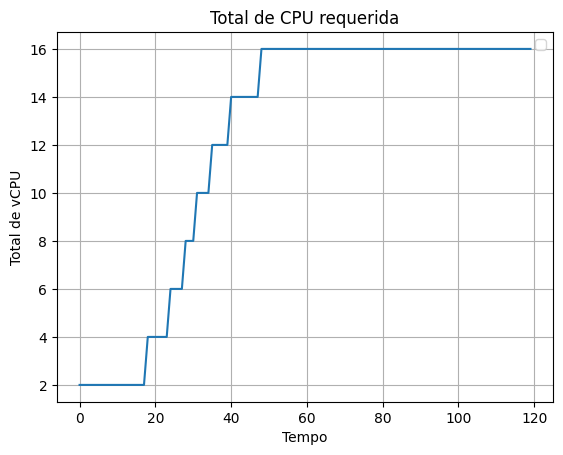

In [222]:
#
fig, ax = plt.subplots()
ax.plot(t, aggregate_total_required_vcpu_peer, label='')
ax.ticklabel_format(style='plain')
ax.grid(True)
plt.xlabel('Tempo')
plt.ylabel('Total de vCPU')
plt.title('Total de CPU requerida')
plt.legend()
plt.show()

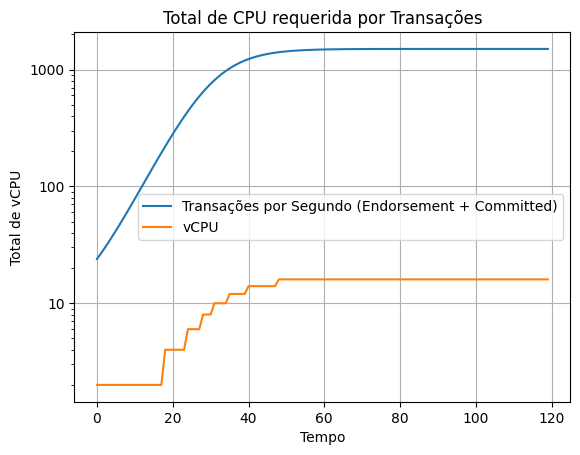

In [223]:
# Plotagem da soma do toal transações estimada no período
fig, ax = plt.subplots()

plt.semilogy(t, peer_endorsement_commited_transactions, label='Transações por Segundo (Endorsement + Committed)')
plt.plot(t, aggregate_total_required_vcpu_peer, label='vCPU')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.grid(True)
plt.xlabel('Tempo')
plt.ylabel('Total de vCPU')
plt.title('Total de CPU requerida por Transações')
plt.legend()
plt.show()

# Cloud Costs

In [224]:
pprint.pprint(CLOUD_PRICING)

{'Additional': 0,
 'NetworkThroughput': {'Pricing': 0.01},
 'Storage': {'Pricing': 0.045},
 'VirtualMachine': {'FilePricing': './Amazon EC2 Instance Comparison.csv',
                    'InstancesTypes': []}}


### Storage 

Estimativas criadas a partir da calculadora AWS. 
É importante ressaltar que cloud providers consideram 730 horas mês,
 isso significa dizer que uma semana, é em média cobrada 730 * 0,25, o que resulta em 182,5 ao contrário de 7 * 24 = 168

A justificativa é porque isso consegue minimizar as divergencias de meses com 28,29,30,31 dias

[Ir para](##CPU-PEER)

In [225]:
def convert_period_month(predict_type): #BASED AWS CALCULATOR
    VOLUME_MONTH_HOURS  = 730
    return {
    'DAY'   : 30 / VOLUME_MONTH_HOURS, #0,04109...
    'WEEK'  : ( VOLUME_MONTH_HOURS / 4 ) / VOLUME_MONTH_HOURS, # 0,25
    'MONTH' : VOLUME_MONTH_HOURS / VOLUME_MONTH_HOURS, # 1
    'YEAR'  : (VOLUME_MONTH_HOURS / VOLUME_MONTH_HOURS) * 12, #12 
    }[predict_type]


convert_period_pricing_month = convert_period_month(PREDICT_TYPE)
print()
total_storage_cost = cumulative_size_GB * (CostPredict().storage_pricing  * convert_period_pricing_month)

12034.04089762955


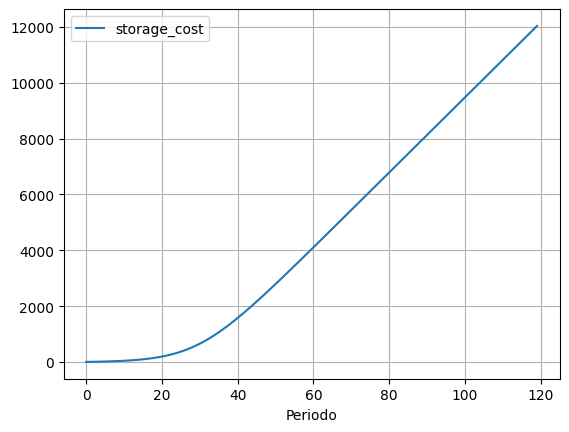

In [226]:
# Plotagem da soma do toal transações estimada no período
print(total_storage_cost[-1])
fig, ax = plt.subplots()
ax.plot(i_period, total_storage_cost, label='storage_cost')

ax.ticklabel_format(style='plain')
ax.grid(True)
plt.xlabel('Periodo')
plt.ylabel('')
plt.title('')
plt.legend()
plt.show()

In [227]:
# EC2
df = pd.read_csv('Amazon EC2 Instance Comparison.csv')
df['vCPUs'] = df['vCPUs'].str.replace(r'\D+', '', regex=True)
df['On Demand'] = df['On Demand'].str.replace(r'[^0-9.]', '', regex=True)

df['vCPUs'] = pd.to_numeric(df['vCPUs'])
df['On Demand'] = pd.to_numeric(df['On Demand'])

#instancias = df[(df['vCPUs'] > aggregate_total_required_vcpu_peer)]

In [228]:
df

,Name,API Name,Instance Memory,vCPUs,Instance Storage,Network Performance,On Demand
0,C6A Large,c6a.large,4.0 GiB,2,EBS only,Up to 12.5 Gigabit,$0.08
1,C6A Extra Large,c6a.xlarge,8.0 GiB,4,EBS only,Up to 12.5 Gigabit,$0.15
2,C6A Double Extra Large,c6a.2xlarge,16.0 GiB,8,EBS only,Up to 12.5 Gigabit,$0.31
3,C6A Quadruple Extra Large,c6a.4xlarge,32.0 GiB,16,EBS only,Up to 12.5 Gigabit,$0.61
4,C6A Eight Extra Large,c6a.8xlarge,64.0 GiB,32,EBS only,12.5 Gigabit,$1.22
5,C6A 12xlarge,c6a.12xlarge,96.0 GiB,48,EBS only,18.75 Gigabit,$1.84
6,C6A 16xlarge,c6a.16xlarge,128.0 GiB,64,EBS only,25 Gigabit,$2.45
7,C6A 24xlarge,c6a.24xlarge,192.0 GiB,96,EBS only,37.5 Gigabit,$3.67
8,C6A 32xlarge,c6a.32xlarge,256.0 GiB,128,EBS only,50 Gigabit,$4.90
9,C6A 48xlarge,c6a.48xlarge,384.0 GiB,192,EBS only,50 Gigabit,$7.34


In [229]:
def provisioned_instance_types(required_vcpu):
    provisioned_vcpu = np.array([])

    # Iterar sobre os elementos do array
    for vcpu in required_vcpu:
        # Verificar se o valor existe na coluna do DataFrame
        if vcpu in df['vCPUs'].values:
            # Se existir, adiciona o valor ao novo array
            type = df[(df['vCPUs'] == vcpu)].iloc[0].to_dict()
            provisioned_vcpu = np.append(provisioned_vcpu, type)
        else:
            # Se não existir, pega o valor mais próximo na coluna do DataFrame
            next_type = df[(df['vCPUs'] > vcpu)].iloc[0].to_dict()
            provisioned_vcpu = np.append(provisioned_vcpu, next_type)

    return provisioned_vcpu

In [230]:
provisioned_instance_peer = provisioned_instance_types(aggregate_total_required_vcpu_peer)
provisioned_instance_osn = provisioned_instance_types(aggregate_total_required_vcpu_osn)

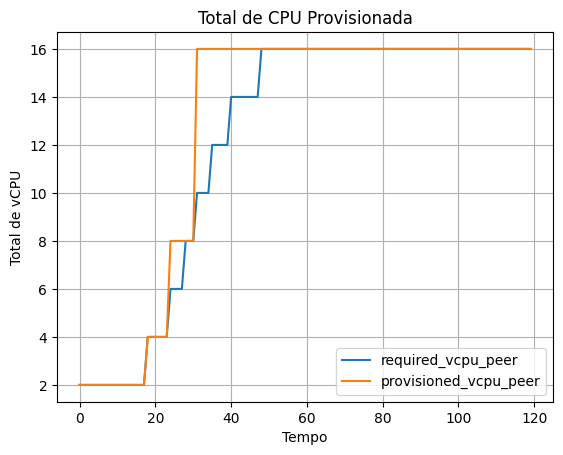

In [231]:
fig, ax = plt.subplots()

ax.plot(t, aggregate_total_required_vcpu_peer, label='required_vcpu_peer')

plot_provisioned_instance_peer = [x['vCPUs'] for x in provisioned_instance_peer]

ax.plot(t, plot_provisioned_instance_peer, label='provisioned_vcpu_peer')


ax.ticklabel_format(style='plain')
ax.grid(True)
plt.xlabel('Tempo')
plt.ylabel('Total de vCPU')
plt.title('Total de CPU Provisionada')
plt.legend()
plt.show()

In [232]:
def convert_period_hours(predict_type):
    
    return {
    'DAY': 24,
    'WEEK': 730 / 4,
    'MONTH': 730, # Providers consideram 730 por mes
    'YEAR': 730 * 12
    }[predict_type]

period_hours = convert_period_hours(PREDICT_TYPE)

cost_provisioned_instance_peer =  np.array([x['On Demand'] for x in provisioned_instance_peer])
cost_provisioned_instance_osn =  np.array([x['On Demand'] for x in provisioned_instance_osn])


computer_cost_period_peer   = cost_provisioned_instance_peer    * period_hours
computer_cost_period_osn    = cost_provisioned_instance_osn     * period_hours


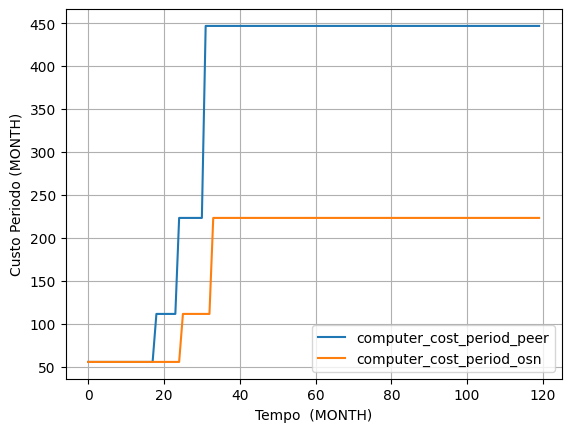

In [233]:
fig, ax = plt.subplots()
#plt.plot(t, computer_cost_period_osn, label='computer_cost_period_osn')
plt.plot(t, computer_cost_period_peer, label='computer_cost_period_peer')
plt.plot(t, computer_cost_period_osn, label='computer_cost_period_osn')


ax.grid(True)
plt.xlabel(f'Tempo  ({PREDICT_TYPE})')
plt.ylabel(f'Custo Periodo ({PREDICT_TYPE})')
plt.title('')
plt.legend()
plt.show()

In [234]:
total_computer_cost_period = computer_cost_period_peer + computer_cost_period_osn

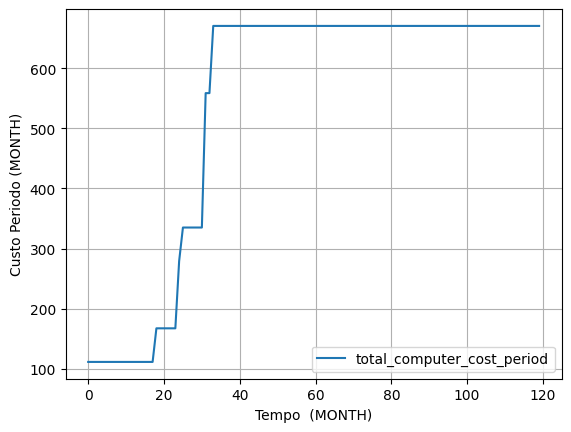

In [235]:
fig, ax = plt.subplots()
#plt.plot(t, computer_cost_period_osn, label='computer_cost_period_osn')
plt.plot(t, total_computer_cost_period, label='total_computer_cost_period')



ax.grid(True)
plt.xlabel(f'Tempo  ({PREDICT_TYPE})')
plt.ylabel(f'Custo Periodo ({PREDICT_TYPE})')
plt.title('')
plt.legend()
plt.show()

# Network

Considera que o peer e o ordering service estão na mesma rede </br>
pacotes de ack são desconsiderados Ex.: Code 200

In [236]:
transaction_size_gb                 = TRANSACTION_SIZE / BYTE_TO_GIGA
estimate_transaction_network_cost   = CLOUD_PRICING['NetworkThroughput']['Pricing'] * transaction_size_gb

network_tput_cost_clients_to_endorsement_peer   =  endorsement_transactions * estimate_transaction_network_cost
network_tput_cost_clients_to_ordering_server    =  total_transactions_by_period * estimate_transaction_network_cost


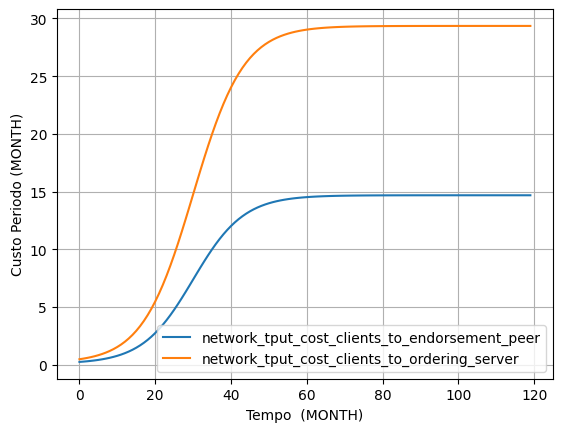

In [237]:
fig, ax = plt.subplots()
#plt.plot(t, computer_cost_period_osn, label='computer_cost_period_osn')
plt.plot(t, network_tput_cost_clients_to_endorsement_peer, label='network_tput_cost_clients_to_endorsement_peer')
plt.plot(t, network_tput_cost_clients_to_ordering_server, label='network_tput_cost_clients_to_ordering_server')


ax.grid(True)
plt.xlabel(f'Tempo  ({PREDICT_TYPE})')
plt.ylabel(f'Custo Periodo ({PREDICT_TYPE})')
plt.title('')
plt.legend()
plt.show()

In [238]:
total_network_throughput_cost = network_tput_cost_clients_to_ordering_server + network_tput_cost_clients_to_endorsement_peer


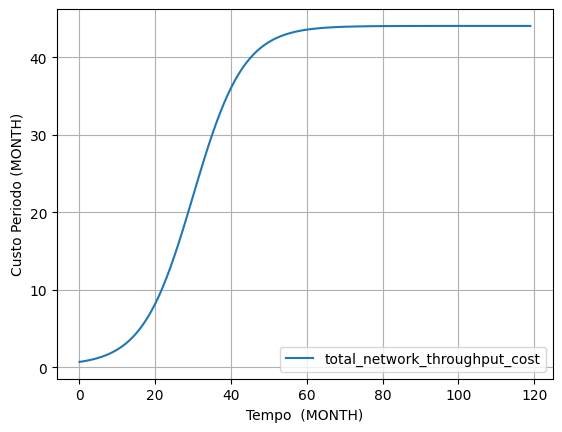

In [239]:
fig, ax = plt.subplots()
#plt.plot(t, computer_cost_period_osn, label='computer_cost_period_osn')
plt.plot(t, total_network_throughput_cost, label='total_network_throughput_cost')

ax.grid(True)
plt.xlabel(f'Tempo  ({PREDICT_TYPE})')
plt.ylabel(f'Custo Periodo ({PREDICT_TYPE})')
plt.title('')
plt.legend()
plt.show()


# CUSTOS TOTAL

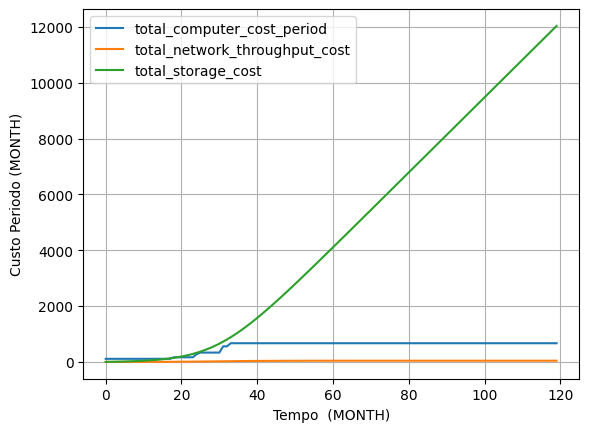

In [240]:
fig, ax = plt.subplots()
#plt.plot(t, computer_cost_period_osn, label='computer_cost_period_osn')
plt.plot(t, total_computer_cost_period, label='total_computer_cost_period')
plt.plot(t, total_network_throughput_cost, label='total_network_throughput_cost')
plt.plot(t, total_storage_cost, label='total_storage_cost')


ax.grid(True)
plt.xlabel(f'Tempo  ({PREDICT_TYPE})')
plt.ylabel(f'Custo Periodo ({PREDICT_TYPE})')
plt.title('')
plt.legend()
plt.show()

In [241]:
total_cost = total_computer_cost_period + total_network_throughput_cost + total_storage_cost

In [242]:
total_cost[-1]

12748.211971034803

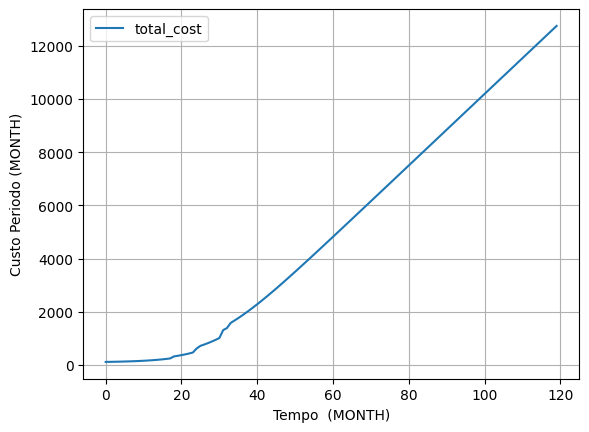

In [243]:
fig, ax = plt.subplots()
#plt.plot(t, computer_cost_period_osn, label='computer_cost_period_osn')
plt.plot(t, total_cost, label='total_cost')



ax.grid(True)
plt.xlabel(f'Tempo  ({PREDICT_TYPE})')
plt.ylabel(f'Custo Periodo ({PREDICT_TYPE})')
plt.title('')
plt.legend()
plt.show()

# ANOTAÇÕES 

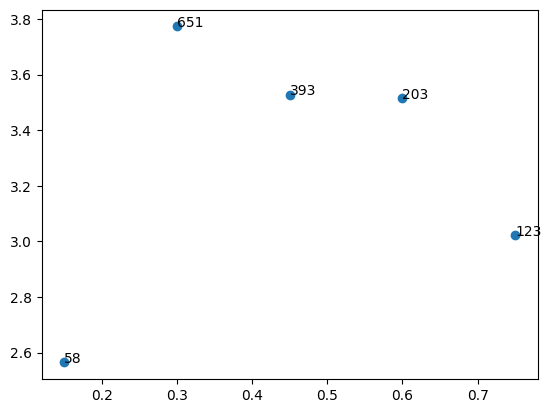

In [244]:
# Anotate
import matplotlib.pyplot as plt
x = [0.15, 0.3, 0.45, 0.6, 0.75]
y = [2.56422, 3.77284, 3.52623, 3.51468, 3.02199]
n = [58, 651, 393, 203, 123]

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))

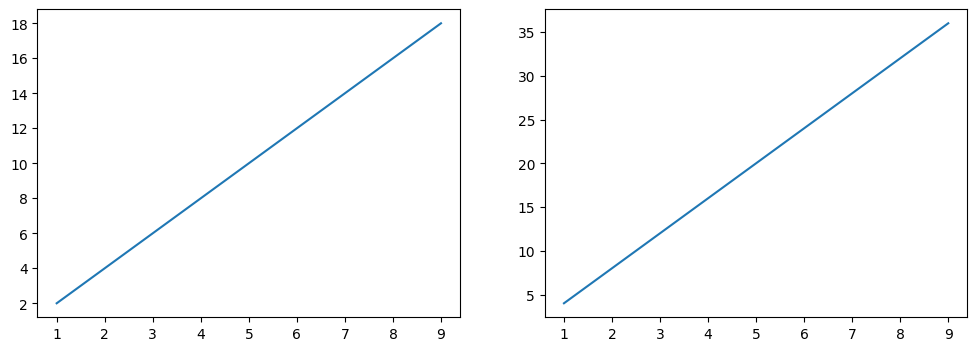

In [245]:
x = np.arange(1,10)
y = x *2 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
#plt.plot(t, computer_cost_period_osn, label='computer_cost_period_osn')
ax1.plot(x,y)

y = x *4 
ax2.plot(x,y)

plt.show()


### ToDo

<input type="checkbox" disabled />     Incluir verificação  não houver modelo com quantiadade de cpus suficiene ex.: Azure com até 72vcpu <br>
<input type="checkbox" disabled />     Tabelas para visualização dos dados do grafico <br>
<input type="checkbox" disabled />     Graficos de barra<br>
<input type="checkbox" disabled checked />     Verificar todas as metricas de calculo. Ex.: Storage /Mes. <br> 
<input type="checkbox" disabled checked />Network ok pois é por GB independente

### Links de plots
https://github.com/norvig/pytudes


Calculadora otimizada vs algo generico